In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
from copy import deepcopy

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import equinox as eqx 

In [3]:
from mc2.utils.final_data_evaluation import (
    FINAL_MATERIALS, TestSet, ResultSet, predict_test_scenarios, validate_result_set, visualize_result_set
)
from mc2.utils.model_evaluation import reconstruct_model_from_file, get_exp_ids

---

In [4]:
FINAL_MATERIALS

['A', 'B', 'C', 'D', 'E']

In [5]:
exp_ids_all_seeds={}
exp_name="final-comp-reduced"
for material_name in FINAL_MATERIALS:
    print("MATERIAL:", material_name)
    mat_ids=[element for element in sorted(get_exp_ids(material_name=material_name, model_type=None)) if exp_name in element]
    mat_ids_unique= list(set(mat_ids))
    [print("    " + f"'{element}'") for element in mat_ids_unique]
    #print(len(get_exp_ids(material_name=material_name, model_type=None)))
    print()
    exp_ids_all_seeds[material_name]=mat_ids_unique

#sorted(get_exp_ids(material_name="E", model_type=None))

MATERIAL: A
    'A_GRU8_final-comp-reduced_1acf73f0_seed3'
    'A_GRU16_final-comp-reduced_3b939dc8_seed1'
    'A_GRU2_final-comp-reduced_4b93d1af_seed2'
    'A_GRU2_final-comp-reduced_ef8a97e0_seed5'
    'A_GRU4_final-comp-reduced_d4dae3d4_seed3'
    'A_GRU32_final-comp-reduced_b12e3229_seed2'
    'A_GRU10_final-comp-reduced_7fd202d7_seed5'
    'A_GRU8_final-comp-reduced_430fd3f5_seed4'
    'A_GRU16_final-comp-reduced_af2466d9_seed4'
    'A_GRU2_final-comp-reduced_ef8a97e0_seed4'
    'A_GRU32_final-comp-reduced_a6d6a717_seed5'
    'A_GRU4_final-comp-reduced_4b52e44c_seed5'
    'A_GRU8_final-comp-reduced_430fd3f5_seed5'
    'A_GRU10_final-comp-reduced_75393ffa_seed1'
    'A_GRU10_final-comp-reduced_75393ffa_seed3'
    'A_GRU32_final-comp-reduced_b12e3229_seed1'
    'A_GRU32_final-comp-reduced_b12e3229_seed3'
    'A_GRU8_final-comp-reduced_1acf73f0_seed2'
    'A_GRU4_final-comp-reduced_d4dae3d4_seed1'
    'A_GRU4_final-comp-reduced_4b52e44c_seed4'
    'A_GRU32_final-comp-reduced_a6d6a71

In [6]:
test_data = {material_name: TestSet.from_material_name(material_name) for material_name in FINAL_MATERIALS}

Loading data for A:   0%|          | 0/5 [00:00<?, ?it/s]

Loading data for A: 100%|██████████| 5/5 [00:00<00:00, 35.97it/s]
INFO:2026-02-02 15:14:57,287:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2026-02-02 15:14:57 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2026-02-02 15:14:57,289:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2026-02-02 15:14:57 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Loading data for E: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]


In [7]:
from mc2.utils.pretest_evaluation import create_multilevel_df
from mc2.utils.final_data_evaluation import evaluate_test_scenarios

In [8]:
# metrics_per_material = {}
all_results = []
for material_name, exp_ids in exp_ids_all_seeds.items():
    test_set = test_data[material_name]
    for exp_id in exp_ids:
        model = reconstruct_model_from_file(exp_id)
        model_params = model.n_params
        seed = exp_id.split("seed")[-1]
        model_type = exp_id.split("_")[1]
        exp_name = exp_id.split("_")[2]
        num_id = exp_id.split("_")[-2]
        metrics_per_sequence = evaluate_test_scenarios(model, test_set)
        metrics = ['sre_avg', 'sre_95th', 'nere_avg', 'nere_95th']
        averages = {m: sum(d[m] for d in metrics_per_sequence.values()) / len(metrics_per_sequence) for m in metrics}
        all_results.append(
                {
                    "exp_id_without_seed": exp_id.rpartition('_')[0],
                    "exp_id": exp_id,
                    "exp_name": exp_name,
                    "num_id": num_id,
                    "material": material_name,
                    "model_type": model_type,
                    "seed": seed,
                    "n_params": model_params,
                    "sre_avg": averages["sre_avg"],
                    "sre_95th": averages["sre_95th"],
                    "nere_avg": averages["nere_avg"],
                    "nere_95th": averages["nere_95th"],
                }
            )
df_results = pd.DataFrame(all_results)

Found model file at '/home/oliverjs@uni-paderborn.de/mc_2/magnet-challenge-2/data/models/A_GRU8_final-comp-reduced_1acf73f0_seed3.eqx'. Loading model..
Evaluate test data for material:  A
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
	MSE :    3.83 (A/m)²
	WCE :   22.87 A/m
	MSE :    3.13 (A/m)²
	WCE :   26.10 A/m
	MSE :    1.40 (A/m)²
	WCE :   13.33 A/m
Found model file at '/home/oliverjs@uni-paderborn.de/mc_2/magnet-challenge-2/data/models/A_GRU16_final-comp-reduced_3b939dc8_seed1.eqx'. Loading model..
Evaluate test data for material:  A
The model has 1029 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
	MSE :    3.22 (A/m

In [ ]:
# df_best_seeds = df_results.loc[df_results.groupby('exp_id_without_seed')['sre_95th'].idxmin()]

# df_best_seeds = df_best_seeds.reset_index(drop=True)
# df_model_comparison_best = df_best_seeds.groupby("model_type").mean(numeric_only=True).reset_index()

# df_results_spec=df_results[(df_results["n_params"] < 500) & (df_results["material"] != "A")]
# df_model_comparison_spec = df_results_spec.groupby("model_type").mean(numeric_only=True).reset_index()

In [9]:
df_model_comparison = df_results.groupby("model_type").mean(numeric_only=True).reset_index()

### Other Teams

In [10]:
EXTERNAL_TEAMS = [
    {
        "model_type": "Fuzhou", 
        "n_params": 63022, 
        "sre_95th": 12.42 / 100, 
        "nere_95th": 1.91 / 100
    },
    {
        "model_type": "Hefei", 
        "n_params": 6564, 
        "sre_95th": 9.17 / 100, 
        "nere_95th": 1.57 / 100
    },
    {
        "model_type": "Cambridge", 
        "n_params": 1182, 
        "sre_95th": 37.01 / 100, 
        "nere_95th": 9.24 / 100
    },
    {
        "model_type": "Sydney", 
        "n_params": 4777, 
        "sre_95th": 24.63 / 100, 
        "nere_95th": 5.44 / 100
    },
    {
        "model_type": "Gatech", 
        "n_params": 83, 
        "sre_95th": 38.76 / 100, 
        "nere_95th": 7.97 / 100
    },
    {
        "model_type": "SiegenPaderborn", 
        "n_params": 325, 
        "sre_95th": 20.43 / 100, 
        "nere_95th": 3.41 / 100
    },
    ]


In [12]:
df_external = pd.DataFrame(EXTERNAL_TEAMS)

In [13]:
df_combined = pd.concat([df_model_comparison, df_external], ignore_index=True)


In [14]:
import seaborn as sns

In [17]:
def visualize_pareto_final(df, metrics, color_own="blue", color_others="gray", scale_log_metric=True, scale_log_size=True, highlighted_type="GRU", sharex="col", sharey="row"):
    sns.set_theme(style="whitegrid")
    
    df = df.copy()
    df["IsOwn"] = df["model_type"].apply(lambda x: highlighted_type in str(x))
    
    fig, axs = plt.subplots(nrows=1, ncols=len(metrics), sharex=sharex, sharey=sharey,
                            figsize=(6 * len(metrics), 7), squeeze=False)
    
    for i, metric in enumerate(metrics):
        ax = axs[0, i]
        target_col = f"{metric}_95th"
        
        for is_own, group_df in df.groupby("IsOwn"):
            current_color = color_own if is_own else color_others
            
            sns.scatterplot(
                data=group_df,
                x=target_col, 
                y="n_params",
                color=current_color,
                marker="o" if is_own else "s", 
                s=120,
                alpha=0.8,
                ax=ax,
                zorder=3
            )
            
            if not is_own:
                for _, row in group_df.iterrows():
                    ax.text(
                        row[target_col] * 1.05, 
                        row["n_params"], 
                        str(row["model_type"]),
                        fontsize=11,
                        alpha=1,
                        va='center', 
                        color=current_color,
                        fontweight='normal'
                    )

        if scale_log_metric:
            ax.set_xscale("log")
        if scale_log_size:
            ax.set_yscale("log")
            
        unique_params = sorted(df["n_params"].unique())
        ax.set_yticks(unique_params)
        ax.yaxis.set_major_formatter(plt.ScalarFormatter())

        if i == 0:
            ax.set_ylabel("Model Size (Params)", fontsize=12)
        
        label_map = {"sre": "95th Perc. Seq. Rel. Error", "nere": "95th Perc. Energy Rel. Error"}
        ax.set_xlabel(label_map.get(metric, metric), fontsize=12)
        
        ax.grid(True, which="both", ls="--", alpha=0.3)

    plt.tight_layout()
    return fig, axs

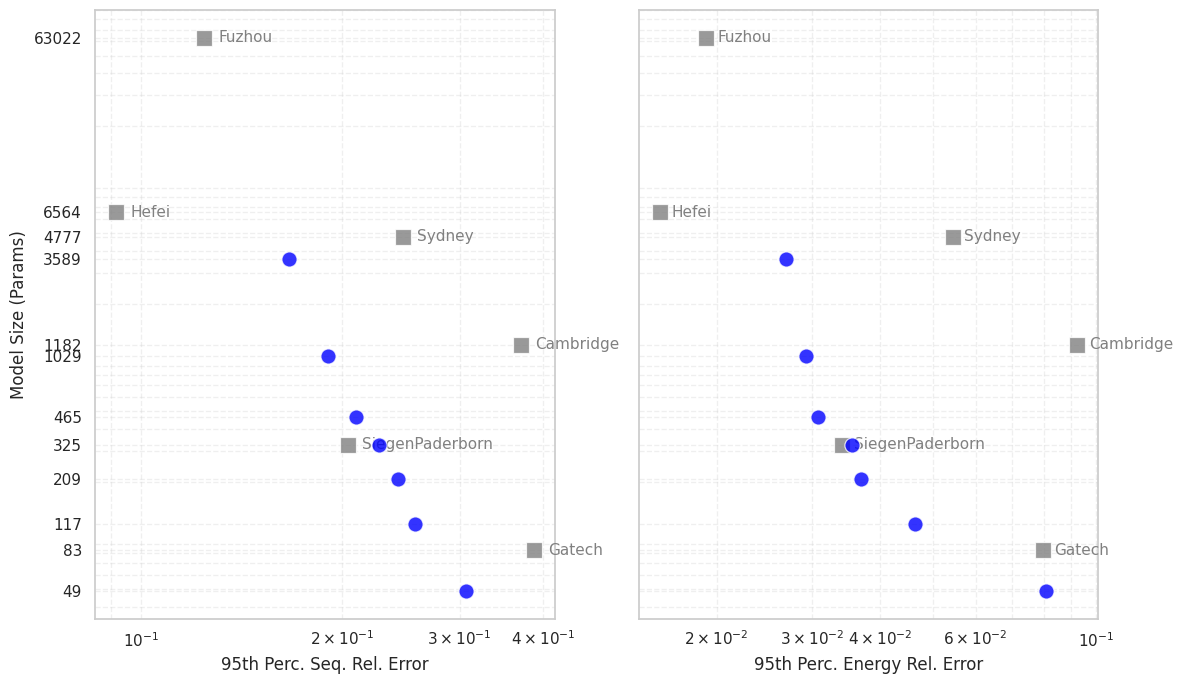

In [18]:
fig, axs=visualize_pareto_final(df_combined, ["sre","nere"], color_own="blue", color_others="gray", scale_log_metric=True, scale_log_size=True, highlighted_type="GRU",sharex="col",sharey="row")